In [2]:
### Execute this first
from astropy.visualization import quantity_support
from astropy import units as u, constants as const
import numpy as np
from tqdm.notebook import tqdm

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x12468a510>

# Small TARDIS: Building a Complete MC Simulation

In this notebook, we'll combine all the functions from notebook 3 to build a complete Monte Carlo radiative transfer simulation for a single shell supernova model.

## Overview

We'll use the following functions from notebook 3:
- `calculate_distance_to_boundary()` - Distance calculations to shell boundaries
- `calculate_doppler_factor()` - Doppler shifts in expanding medium
- `calculate_distance_line()` - Distance to line interactions
- `move_packet()` - Packet movement in spherical geometry
- `scatter_packet()` - Scattering physics and frame transformations

Our goal is to create a complete function that simulates the propagation of many photon packets and produces a synthetic spectrum.

In [6]:
# Functions from notebook 3

def calculate_distance_to_boundary(r, mu, r_inner, r_outer):
    """
    Calculate the distance to the next shell boundary and which boundary is hit.
    """
    if mu > 0:
        # moving outward
        term = r_outer**2 + (mu**2 - 1.0) * r**2
        distance = -r * mu + np.sqrt(term)
        return distance, True
    else:
        # moving inward
        check = r_inner**2 + (mu**2 - 1.0) * r**2
        if check >= 0.0:
            distance = -r * mu - np.sqrt(check)
            return distance, False
        else:
            # misses inner boundary, will hit outer boundary
            term = r_outer**2 + (mu**2 - 1.0) * r**2
            distance = -r * mu + np.sqrt(term)
            return distance, True

def calculate_doppler_factor(r, mu, time_explosion):
    """
    Calculate the Doppler factor for a photon packet in expanding ejecta.
    """
    # Calculate expansion velocity
    v = r / time_explosion
    
    # Calculate dimensionless velocity 
    beta = (v / const.c).to(1)
    
    # Calculate Doppler factor
    doppler_factor = (1 - mu * beta)
    
    return doppler_factor

def calculate_distance_line(r, mu, nu_rest, nu_line, time_explosion):
    """
    Calculate distance until photon packet is in resonance with a spectral line.
    """
    # Calculate Doppler factor using existing function
    doppler_factor = calculate_doppler_factor(r, mu, time_explosion)
    
    # Transform to comoving frame
    comov_nu = nu_rest * doppler_factor
    
    # Check if resonance is possible and calculate distance
    if comov_nu > nu_line:
        distance = (comov_nu - nu_line) / nu_rest * const.c * time_explosion
    else:
        distance = 1e99 * u.cm  # Very large distance - no interaction
    
    return distance.to(u.cm)

def move_packet(r, mu, distance):
    """
    Move a packet through spherical geometry.
    """
    # Calculate new radius using law of cosines
    new_r = np.sqrt(r**2 + distance**2 + 2*r*distance*mu)
    
    # Calculate new direction cosine
    new_mu = (mu*r + distance) / new_r
    
    return new_r, new_mu

# SOLUTION: Packet scattering function

def scatter_packet(r, mu, energy, nu_line, time_explosion):
    """
    Handle packet scattering frame transformations when scattering occurs.
    
    Note: This function assumes scattering WILL occur - the scattering decision
    (optical depth sampling) should be handled outside this function.
    
    Parameters
    ----------
    r : astropy Quantity
        Current radial position
    mu : float
        Current direction cosine  
    energy : float
        Current packet energy in lab frame
    nu_line : astropy Quantity
        Line rest frequency
    time_explosion : astropy Quantity
        Time since explosion
        
    Returns
    -------
    new_mu : float
        New direction cosine after isotropic scattering
    new_energy : float
        New packet energy in lab frame (conserved in comoving frame)
    new_nu : astropy Quantity
        New packet frequency in lab frame (line frequency in comoving frame)
    """
    # Step 1: Calculate current expansion velocity and beta
    v = r / time_explosion
    beta = (v / const.c).to(1)  # dimensionless
    
    # Step 2: Transform energy to comoving frame  
    current_doppler_factor = (1 - mu * beta)
    comov_energy = energy * current_doppler_factor
    
    # Step 3: Isotropic scattering - new random direction
    new_mu = np.random.uniform(-1, 1)
    
    # Step 4: Transform back to lab frame with new direction
    new_doppler_factor = (1 - new_mu * beta)
    new_energy = comov_energy / new_doppler_factor  # conserve energy in comoving frame
    new_nu = nu_line / new_doppler_factor  # line frequency in comoving frame, maintains units
    
    return u.Quantity(new_mu, 1), u.Quantity(new_energy, u.erg), u.Quantity(new_nu, u.Hz)

def single_packet_loop(initial_r, initial_mu, initial_nu, initial_energy, 
                          r_inner, r_outer, line_nu, time_explosion, tau_sobolev):
    """
    Propagate a single packet until it escapes or is captured.
    
    Parameters
    ----------
    initial_r : astropy Quantity
        Initial radial position
    initial_mu : float
        Initial direction cosine
    initial_nu : astropy Quantity
        Initial frequency
    initial_energy : float
        Initial energy
    r_inner, r_outer : astropy Quantity
        Shell boundaries
    line_nu : astropy Quantity
        Line rest frequency
    time_explosion : astropy Quantity
        Time since explosion
    tau_sobolev : float
        Sobolev optical depth
        
    Returns
    -------
    final_state : dict
        Dictionary with keys: 'escaped', 'r', 'mu', 'nu', 'energy', 'n_interactions'
    """
    # Initialize packet state
    r, mu, nu, energy = initial_r, initial_mu, initial_nu, initial_energy
    n_interactions = 0
    
    # Propagation loop
    while True:
        # Calculate distances to boundary and line
        distance_boundary, is_outer = calculate_distance_to_boundary(r, mu, r_inner, r_outer)
        distance_line = calculate_distance_line(r, mu, nu, line_nu, time_explosion)
        
        # Choose closer event and move packet
        if distance_line < distance_boundary:
            # Line interaction - move and potentially scatter
            r, mu = move_packet(r, mu, distance_line)
            
            # Check for scattering using tau_sobolev
            z = np.random.random()
            if z < 1 - np.exp(-tau_sobolev):
                # Scattering occurs
                mu, energy, nu = scatter_packet(r, mu, energy, line_nu, time_explosion)
                n_interactions += 1
        else:
            # Boundary hit - move to boundary and return final state
            r, mu = move_packet(r, mu, distance_boundary)
            return {
                'escaped': is_outer,
                'r': r,
                'mu': mu, 
                'nu': nu,
                'energy': energy,
                'n_interactions': n_interactions}

## Task 1: Implement Multi-Packet Monte Carlo Simulation

Let's start by creating the main Monte Carlo simulation function that will propagate photon packets through the supernova ejecta.

### Your Task:

Create a function `run_monte_carlo_simulation()` that:

1. **Takes pre-generated packet arrays** as input 
2. **Propagates each packet** using the `single_packet_loop` function from notebook 3
3. **Returns arrays of escaped packet properties** for further analysis
4. **Uses tqdm for progress tracking** - `tqdm` creates a progress bar that shows how many packets have been processed and estimated time remaining

### Algorithm:

1. **Initialize result tracking** for escaped packets
2. **Loop through all packets** with `tqdm` progress bar
3. **For each packet**: Call `single_packet_loop()` with packet's initial conditions
4. **Store escaped packet properties** in separate arrays
5. **Return the escaped packet arrays**

### Expected Output:

Your function should return three arrays containing only the **escaped** packets:
- `packets_escaped_nus`: Final frequencies of escaped packets
- `packets_escaped_mus`: Final directions of escaped packets  
- `packets_escaped_energies`: Final energies of escaped packets

These arrays will be used for spectral analysis in subsequent cells.

In [ ]:
# Task 1: Implement Multi-Packet Monte Carlo Simulation

def run_monte_carlo_simulation(packets_initial_nus, packets_initial_mus, packets_initial_energies, 
                              line_nu, tau_sobolev=1.0):
    """
    Run Monte Carlo simulation with pre-generated packet arrays.
    
    Returns arrays of escaped packet properties for spectral analysis.
    """
    
    # Set random seed for reproducible scattering results
    np.random.seed(123)
    
    # Initialize lists to store escaped packet properties
    packets_escaped_nus = ?      # List for escaped packet frequencies
    packets_escaped_mus = ?      # List for escaped packet directions
    packets_escaped_energies = ? # List for escaped packet energies
    
    # Loop through packets with tqdm progress bar
    for i in tqdm(range(len(packets_initial_nus)), desc="Propagating packets"):
        # Get packet parameters
        packet_nu = ?    # Get frequency for packet i
        packet_mu = ?    # Get direction for packet i
        packet_energy = ? # Get energy for packet i
        
        # Propagate single packet using single_packet_loop
        final_state = single_packet_loop(
            initial_r=R_INNER,
            initial_mu=packet_mu,
            initial_nu=packet_nu,
            initial_energy=packet_energy,
            r_inner=R_INNER,
            r_outer=R_OUTER,
            line_nu=line_nu,
            time_explosion=TIME_EXPLOSION,
            tau_sobolev=tau_sobolev
        )
        
        # Store only escaped packet properties
        if final_state['escaped']:
            packets_escaped_nus.append(?)     # Store final frequency
            packets_escaped_mus.append(?)     # Store final direction
            packets_escaped_energies.append(?) # Store final energy
    
    # Convert lists to arrays - handle astropy Quantities properly
    return (u.Quantity(?),    # For frequency list with units
            np.array(?),      # For unitless direction list  
            u.Quantity(?)     # For energy list with units
           )

SyntaxError: invalid syntax (1938996776.py, line 13)

In [3]:
# SOLUTION: Task 1 - Implement Multi-Packet Monte Carlo Simulation

def run_monte_carlo_simulation(packets_initial_nus, packets_initial_mus, packets_initial_energies, 
                              line_nu, tau_sobolev=1.0):
    """
    Run Monte Carlo simulation with pre-generated packet arrays.
    
    Returns arrays of escaped packet properties for spectral analysis.
    """
    
    # Set random seed for reproducible scattering results
    np.random.seed(123)
    
    # Initialize lists to store escaped packet properties
    packets_escaped_nus = []
    packets_escaped_mus = []
    packets_escaped_energies = []
    
    # Loop through packets with tqdm progress bar
    for i in tqdm(range(len(packets_initial_nus)), desc="Propagating packets"):
        # Get packet parameters
        packet_nu = packets_initial_nus[i]
        packet_mu = packets_initial_mus[i] 
        packet_energy = packets_initial_energies[i]
        
        # Propagate single packet using single_packet_loop
        final_state = single_packet_loop(
            initial_r=R_INNER,
            initial_mu=packet_mu,
            initial_nu=packet_nu,
            initial_energy=packet_energy,
            r_inner=R_INNER,
            r_outer=R_OUTER,
            line_nu=line_nu,
            time_explosion=TIME_EXPLOSION,
            tau_sobolev=tau_sobolev
        )
        
        # Store only escaped packet properties
        if final_state['escaped']:
            packets_escaped_nus.append(final_state['nu'])
            packets_escaped_mus.append(final_state['mu'])
            packets_escaped_energies.append(final_state['energy'])
    
    # Convert lists to arrays and return - handle astropy Quantities properly
    return (u.Quantity(packets_escaped_nus), 
            np.array(packets_escaped_mus), 
            u.Quantity(packets_escaped_energies))

## $\blacktriangleright$ Task 2: Generate Packets and Run Complete Simulation

Now let's generate the initial packet conditions and run the complete Monte Carlo simulation. This task combines packet generation with frame transformation and simulation execution.

### Physical Background: Photosphere and Frame Transformations

In TARDIS, packets are emitted from the **inner boundary as blackbody radiation from the photosphere**. This process involves important frame transformation physics:

**The Photosphere ("Surface of Last Scattering")**
- The inner boundary represents the **photosphere** - the last surface where photons can scatter
- Below this surface, the material is optically thick and photons are trapped

**Frame Transformation Physics**
When packets are initially created, they represent photons **sitting in the material** (comoving frame). To become true "r-packets" that can propagate through the simulation, they must be transformed to the **lab frame**:

1. **Comoving frame**: Packets are at rest relative to the expanding material
2. **Lab frame**: Packets have proper relativistic Doppler shifts due to the expansion

**Transformation equations**:
- $\nu_{lab} = \nu_{comoving} / D$ where $D = (1 - \mu\beta)$ is the Doppler factor
- $E_{lab} = E_{comoving} / D$ (energy conservation in appropriate frame)

**Simplified Blackbody Sampling**
Ideally, we would sample frequencies from the Planck function $B_\nu(T)$. For this exercise we'll make a simplification:

**Simplification**: Over the narrow wavelength region needed to explore a single spectral line, we assume $B_\nu$ doesn't change significantly, so we can **sample uniformly in wavelength space**.

**Why uniform in wavelength?** Since we ultimately want to analyze spectra in wavelength space ($L_\lambda$ vs $\lambda$), it's more natural to start with a uniform distribution in wavelength and then convert to frequency for the simulation physics.

### $\blacktriangleright$ Your Task: Generate, Transform, and Simulate

**Step 1: Generate Packet Arrays**
Create initial packet conditions **in the comoving frame**:

**1a-1d. Basic Packet Generation**
- **Rest wavelength range**: Use 6000-6300 Angstrom (significantly bluer than the 6373 Angstrom Si II line)
- **Wavelength sampling**: Uniform sampling in **wavelength space** (flat in $\lambda$)
- **Frequency conversion**: Convert wavelengths to frequencies using $\nu = c/\lambda$
- **Direction sampling**: Use `np.sqrt(np.random.uniform(0, 1))` for proper surface emission
- **Energy**: All packets start with equal energy (1.0 erg) in comoving frame

**Step 2: Frame Transformation (CRUCIAL PHYSICS STEP)**
Transform packets from **comoving frame** to **lab frame**:

**2a. Calculate Doppler Factors**
- Use `calculate_doppler_factor()` with `R_INNER`, packet directions, and `TIME_EXPLOSION`
- This function should work on arrays automatically

**2b. Transform to Lab Frame**  
- **Frequencies**: $\nu_{lab} = \nu_{comoving} / D$
- **Energies**: $E_{lab} = E_{comoving} / D$
- **Directions**: No change (geometric quantity)

**Step 3: Run the Complete Simulation**
Use your `run_monte_carlo_simulation()` function with the **lab-frame** packets.

### Key Physics Insights:

**Why this frame transformation is essential:**
- **Without transformation**: Packets would have wrong frequencies/energies for the simulation
- **With transformation**: Packets correctly represent photons emerging from the photosphere
- **Physical meaning**: This mimics how real photons are "born" at the photosphere and then propagate

**Why uniform wavelength sampling:**
- **Spectral analysis**: Final spectra are typically analyzed in wavelength space
- **Natural distribution**: Uniform in $\lambda$ gives more intuitive starting distribution
- **Frequency conversion**: Physics calculations still use frequencies via $\nu = c/\lambda$

In [4]:
# Physical parameters for the simulation
TIME_EXPLOSION = 15 * u.day
V_INNER = 8000 * u.km / u.s
V_OUTER = 12000 * u.km / u.s

# Calculate radii using homologous expansion R = V * t
R_INNER = (V_INNER * TIME_EXPLOSION).to(u.cm)
R_OUTER = (V_OUTER * TIME_EXPLOSION).to(u.cm)

# Silicon II spectral line (iconic feature of Type Ia supernovae)
LINE_LAMBDA = 6373.133 * u.Angstrom
LINE_NU = LINE_LAMBDA.to(u.Hz, equivalencies=u.spectral())



In [ ]:
# Task 2: Generate Packets and Run Complete Simulation

# Step 1: Generate Packet Parameter Arrays

# Physical parameters for packet generation (rest wavelengths)
PACKETS_LAMBDA_START = 5800.0 * u.Angstrom  # Blue end (much bluer than 6373 Angstrom line)
PACKETS_LAMBDA_END = 7000.0 * u.Angstrom    # Red end (still bluer than 6373 Angstrom line) 
N_PACKETS = 10000  # Number of packets to generate

# Set random seed for reproducible results
np.random.seed(42)

# Step 1a: Create random wavelength array (uniform in wavelength space)
# Sample uniformly in wavelength to get flat distribution in lambda
packets_initial_lambdas = ?  # Use np.random.uniform to sample between PACKETS_LAMBDA_START and PACKETS_LAMBDA_END

# Step 1b: Convert wavelengths to frequencies
# Convert from wavelength to frequency: nu = c/lambda
packets_initial_nus = ?  # Convert packets_initial_lambdas to Hz using .to(u.Hz, equivalencies=u.spectral())

# Step 1c: Generate surface-sampled directions
# Sample uniformly, then take square root for proper surface emission
packets_initial_mus = ?   # Use np.sqrt of uniform sampling for surface emission

# Step 1d: Create equal energy array  
# All packets start with 1.0 erg
packets_initial_energies = ?  # Create array of ones with proper units

# Step 2: Transform from Comoving Frame to Lab Frame
# IMPORTANT PHYSICS: The packets we generated above are in the comoving frame 
# (as if sitting in the material at the photosphere). To make them true "r-packets" 
# for the simulation, we need to transform them to the lab frame.

# Step 2a: Calculate Doppler factors for all packets at inner boundary
# All packets start at R_INNER with their respective directions
doppler_factors = ?  # Use calculate_doppler_factor(R_INNER, packets_initial_mus, TIME_EXPLOSION)

# Step 2b: Transform frequencies and energies to lab frame
# In lab frame: nu_lab = nu_comoving / doppler_factor, energy_lab = energy_comoving / doppler_factor
packets_lab_nus = ?        # Transform frequencies to lab frame
packets_lab_energies = ?   # Transform energies to lab frame

# Step 3: Run the Complete Simulation
# Use the function you implemented in Task 1 with the lab-frame packets
packets_escaped_nus, packets_escaped_mus, packets_escaped_energies = run_monte_carlo_simulation(
    packets_initial_nus=packets_lab_nus,
    packets_initial_mus=packets_initial_mus,  
    packets_initial_energies=packets_lab_energies,
    line_nu=LINE_NU,
    tau_sobolev=1.0
)

print(f"Generated {N_PACKETS} packets")
print(f"Simulation complete: {len(packets_escaped_nus)} packets escaped")

In [7]:
# SOLUTION: Task 2 - Generate Packets and Run Complete Simulation

# Step 1: Generate Packet Parameter Arrays

# Physical parameters for packet generation (rest wavelengths)
PACKETS_LAMBDA_START = 5800.0 * u.Angstrom  # Blue end (much bluer than 6373 Angstrom line)
PACKETS_LAMBDA_END = 7000.0 * u.Angstrom    # Red end (still bluer than 6373 Angstrom line) 
N_PACKETS = 100000

# Set random seed for reproducible results
np.random.seed(42)

# Step 1a: Create random wavelength array (uniform in wavelength space)
# Sample uniformly in wavelength to get flat distribution in lambda
packets_initial_lambdas = np.random.uniform(PACKETS_LAMBDA_START.value, PACKETS_LAMBDA_END.value, N_PACKETS) * u.Angstrom

# Step 1b: Convert wavelengths to frequencies
# Convert from wavelength to frequency: nu = c/lambda
packets_initial_nus = packets_initial_lambdas.to(u.Hz, equivalencies=u.spectral())

# Step 1c: Generate surface-sampled directions
# Use sqrt(U(0,1)) for proper surface emission sampling
packets_initial_mus = np.sqrt(np.random.uniform(0, 1, N_PACKETS))

# Step 1d: Create equal energy array  
packets_initial_energies = np.ones(N_PACKETS) * u.erg

print(f"Generated {N_PACKETS} packets with wavelength range: {packets_initial_lambdas.min():.1f} to {packets_initial_lambdas.max():.1f}")
print(f"Corresponding frequency range: {packets_initial_nus.max():.2e} to {packets_initial_nus.min():.2e} Hz")

# Step 2: Transform from Comoving Frame to Lab Frame
# IMPORTANT PHYSICS: The packets we generated above are in the comoving frame 
# (as if sitting in the material at the photosphere). To make them true "r-packets" 
# for the simulation, we need to transform them to the lab frame.

# Step 2a: Calculate Doppler factors for all packets at inner boundary
doppler_factors = calculate_doppler_factor(R_INNER, packets_initial_mus, TIME_EXPLOSION)

# Step 2b: Transform frequencies and energies to lab frame
# In lab frame: nu_lab = nu_comoving / doppler_factor, energy_lab = energy_comoving / doppler_factor
packets_lab_nus = packets_initial_nus / doppler_factors
packets_lab_energies = packets_initial_energies / doppler_factors

print(f"Frame transformation complete: lab frame wavelength range: {packets_lab_nus.max().to(u.Angstrom, equivalencies=u.spectral()):.1f} to {packets_lab_nus.min().to(u.Angstrom, equivalencies=u.spectral()):.1f}")

# Step 3: Run the Complete Simulation
packets_escaped_nus, packets_escaped_mus, packets_escaped_energies = run_monte_carlo_simulation(
    packets_initial_nus=packets_lab_nus,
    packets_initial_mus=packets_initial_mus,  
    packets_initial_energies=packets_lab_energies,
    line_nu=LINE_NU,
    tau_sobolev=1.0
)

print(f"Simulation complete: {len(packets_escaped_nus)} packets escaped")

Generated 100000 packets with wavelength range: 5800.0 Angstrom to 7000.0 Angstrom
Corresponding frequency range: 5.17e+14 Hz to 4.28e+14 Hz Hz
Frame transformation complete: lab frame wavelength range: 5646.6 Angstrom to 6986.2 Angstrom


Propagating packets:   0%|          | 0/100000 [00:00<?, ?it/s]

Simulation complete: 98556 packets escaped


## $\blacktriangleright$ Task 3: Create TARDIS-Style Spectrum Analysis

Now let's create a proper synthetic spectrum following the TARDIS methodology. This involves two key steps: calculating the luminosity density in frequency space, then converting to wavelength space.

### TARDIS Spectral Analysis Method:

**Step 1: Calculate Luminosity Density in Frequency Space ($L_\nu$)**
- Use `np.histogram()` to bin escaped packet frequencies with energy weights
- This gives total luminosity in each frequency bin
- Convert to luminosity density by dividing by bin width: $L_\nu = \text{luminosity} / \Delta\nu$

**Step 2: Convert to Wavelength Space ($L_\lambda$)**  
- Transform from frequency density to wavelength density using: $L_\lambda = L_\nu \times \nu^2/c$
- This accounts for the Jacobian transformation: $d\nu/d\lambda = \nu^2/c$
- Alternatively: $L_\lambda = L_\nu \times \nu/\lambda$ (equivalent form)

### $\blacktriangleright$ Your Task:

**Part A: Calculate Luminosity Density in Frequency ($L_\nu$)**
1. **Create frequency bins** for the spectrum analysis
2. **Calculate total luminosity** using `np.histogram(frequencies, weights=energies, bins=frequency_grid)`
3. **Calculate bin widths** ($\Delta\nu$) for each frequency bin  
4. **Calculate luminosity density**: $L_\nu = \text{total\_luminosity} / \Delta\nu$

**Part B: Convert to Wavelength Space ($L_\lambda$)**
1. **Calculate frequency centers** for each bin
2. **Transform to luminosity density in wavelength**: $L_\lambda = L_\nu \times \nu^2/c$
3. **Convert frequency centers to wavelength** for plotting
4. **Plot $L_\lambda$ vs $\lambda$** to see the spectral line profile

### Physics Background:

**Why this transformation matters:**
- **Luminosity density**: Measures energy per unit frequency ($L_\nu$) or per unit wavelength ($L_\lambda$)
- **Jacobian transformation**: Required when changing variables in density functions
- **Spectral shape**: Line profiles look different in frequency vs wavelength space due to this transformation

This approach mimics how TARDIS generates synthetic spectra from Monte Carlo packet data.

In [ ]:
# Task 3: Create TARDIS-Style Spectrum Analysis

import matplotlib.pyplot as plt

# Part A: Calculate Luminosity Density in Frequency (L_nu)

# Step 1: Create frequency bins for the spectrum
MIN_FREQ = ?  # Minimum frequency from packets_escaped_nus
MAX_FREQ = ?  # Maximum frequency from packets_escaped_nus
N_BINS = 50   # Number of frequency bins

# Create frequency grid (bin edges)
spectrum_frequency_grid = ?  # Use np.linspace to create frequency bins with MIN_FREQ, MAX_FREQ, N_BINS+1

# Step 2: Calculate total luminosity in each frequency bin (TARDIS method)
# This follows: np.histogram(emitted_packet_nu, weights=emitted_packet_luminosity, bins=frequency_grid)
total_luminosity, _ = np.histogram(
    ?,        # frequencies to bin (packets_escaped_nus)
    weights=?, # weights for each frequency (packets_escaped_energies) 
    bins=?     # frequency bins (spectrum_frequency_grid)
)

# Step 3: Calculate frequency bin centers and widths
spectrum_frequency_centers = ?  # Calculate bin centers: (grid[:-1] + grid[1:]) / 2
delta_frequency = ?             # Calculate bin widths: grid[1:] - grid[:-1]

# Step 4: Calculate luminosity density in frequency (L_nu)
# L_nu = total_luminosity / Delta_nu
luminosity_density_nu = ?  # Divide total_luminosity by delta_frequency

# Part B: Convert to Wavelength Space (L_lambda)

# Step 5: Transform to luminosity density in wavelength
# L_lambda = L_nu * nu^2/c (Jacobian transformation)
luminosity_density_lambda = ?  # Use luminosity_density_nu * spectrum_frequency_centers**2 / const.c

# Step 6: Convert frequency centers to wavelength for plotting
spectrum_wavelength_centers = ?  # Convert spectrum_frequency_centers to wavelength

# Step 7: Plot the synthetic spectrum in wavelength space
plt.figure(figsize=(10, 6))
plt.plot(?, ?, 'b-', drawstyle='steps', linewidth=2, label='Synthetic Spectrum')  # Plot wavelength vs luminosity_density_lambda
plt.axvline(LINE_LAMBDA.value, color='red', linestyle='--', linewidth=2, label='Si II rest wavelength')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('L_lambda (erg/s/Angstrom)')
plt.title('Luminosity Density vs Wavelength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Created spectrum with {N_BINS} frequency bins")
print(f"Wavelength range: {spectrum_wavelength_centers.min():.1f} to {spectrum_wavelength_centers.max():.1f} Angstrom")

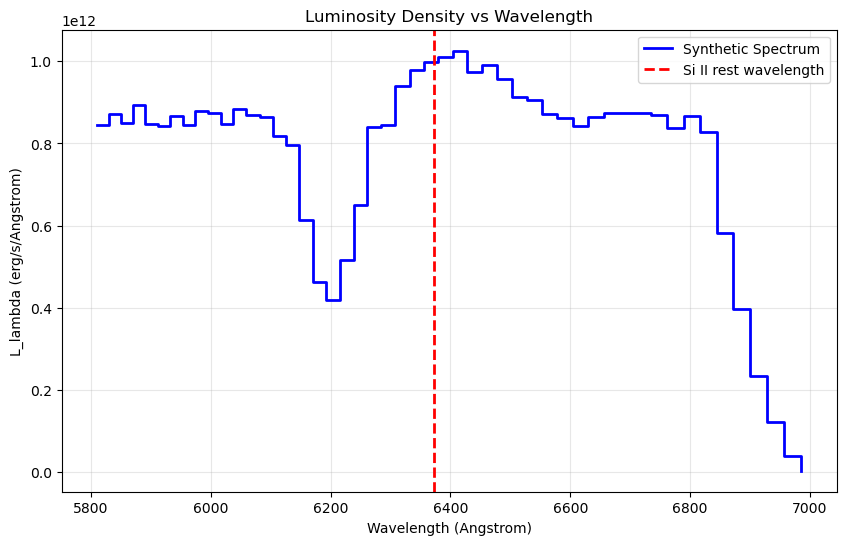

Created spectrum with 50 frequency bins
Wavelength range: 5810.0 Angstrom to 6985.5 Angstrom Angstrom
Peak L_lambda: 1.03e+12 Hz erg s / m erg/s/Angstrom


In [9]:
# SOLUTION: Task 3 - Create TARDIS-Style Spectrum Analysis

import matplotlib.pyplot as plt

# Part A: Calculate Luminosity Density in Frequency (L_nu)

# Step 1: Create frequency bins for the spectrum
MIN_FREQ = packets_initial_nus.min()
MAX_FREQ = packets_initial_nus.max()
N_BINS = 50

# Create frequency grid (bin edges)
spectrum_frequency_grid = np.linspace(MIN_FREQ, MAX_FREQ, N_BINS + 1)

# Step 2: Calculate total luminosity in each frequency bin (TARDIS method)
# This follows: np.histogram(emitted_packet_nu, weights=emitted_packet_luminosity, bins=frequency_grid)
total_luminosity, _ = np.histogram(
    packets_escaped_nus,               # frequencies to bin
    weights=packets_escaped_energies,  # weights (energies/luminosities)
    bins=spectrum_frequency_grid       # frequency bins
)

# Step 3: Calculate frequency bin centers and widths
spectrum_frequency_centers = (spectrum_frequency_grid[:-1] + spectrum_frequency_grid[1:]) / 2
delta_frequency = spectrum_frequency_grid[1:] - spectrum_frequency_grid[:-1]

# Step 4: Calculate luminosity density in frequency (L_nu)
# L_nu = total_luminosity / Delta_nu
luminosity_density_nu = total_luminosity / delta_frequency

# Part B: Convert to Wavelength Space (L_lambda)

# Step 5: Transform to luminosity density in wavelength
# L_lambda = L_nu * nu^2/c (Jacobian transformation)
luminosity_density_lambda = luminosity_density_nu * spectrum_frequency_centers**2 / const.c

# Step 6: Convert frequency centers to wavelength for plotting
spectrum_wavelength_centers = spectrum_frequency_centers.to(u.Angstrom, equivalencies=u.spectral())

# Step 7: Plot the synthetic spectrum in wavelength space
plt.figure(figsize=(10, 6))
plt.plot(spectrum_wavelength_centers, luminosity_density_lambda, drawstyle='steps', color='b', linewidth=2, label='Synthetic Spectrum')
plt.axvline(LINE_LAMBDA.value, color='red', linestyle='--', linewidth=2, label='Si II rest wavelength')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('L_lambda (erg/s/Angstrom)')
plt.title('Luminosity Density vs Wavelength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Created spectrum with {N_BINS} frequency bins")
print(f"Wavelength range: {spectrum_wavelength_centers.min():.1f} to {spectrum_wavelength_centers.max():.1f} Angstrom")
print(f"Peak L_lambda: {luminosity_density_lambda.max():.2e} erg/s/Angstrom")

## $\blacktriangleright$ Task 4: Spectral Analysis and Interpretation

Now that you have created a synthetic spectrum from your Monte Carlo simulation, let's analyze what you see and understand the physical processes that create the spectral features.

### $\blacktriangleright$ Your Task: Analyze the Spectrum

Look at the spectrum you created in Task 3 and consider the following questions. Write your thoughts and observations in the markdown cell below:

**Spectral Features to Consider:**

1. **Overall Shape**: Describe the general shape of the spectrum around the Si II line at 6373 Å
   - Is it symmetric or asymmetric?
   - Are there any distinctive features (peaks, troughs, wings)?

2. **Comparison to Rest Wavelength**: 
   - How does the spectrum relate to the rest wavelength of the Si II line (red dashed line)?
   - Is there emission, absorption, or both?

3. **Physical Interpretation**:
   - What physical processes in the expanding supernova ejecta could create these features?
   - Think about the Doppler shifts from expansion, scattering effects, and photon escape

4. **Astronomical Context**:
   - Does this spectral profile remind you of anything you've seen in astronomy?
   - What types of astrophysical objects might show similar spectral features?

**Hints for Analysis:**
- Consider how packets with different velocities (directions $\mu$) contribute to different parts of the spectrum
- Think about which packets escape more easily and which undergo more scattering
- Remember that the expanding material creates Doppler shifts: blue-shifted material moves toward us, red-shifted material moves away

### Instructions:
- Write your analysis in the markdown cell below
- Be specific about what you observe in the spectrum
- Try to connect the spectral features to the physics of radiative transfer in expanding media
- Don't worry about getting everything "right" - the goal is to think critically about the connection between physics and observations

# Task 4: Your Spectral Analysis

**Write your observations and analysis here:**

## 1. Spectral Shape Description:
[Describe what you see in the spectrum - is it symmetric? Are there peaks and troughs?]

## 2. Relationship to Rest Wavelength:
[How does the spectrum compare to the Si II rest wavelength at 6373 Å?]

## 3. Physical Interpretation:
[What physical processes could create the features you observe?]

## 4. Astronomical Connection:
[Does this remind you of spectra from particular types of astronomical objects?]

## 5. Additional Thoughts:
[Any other observations or questions about the spectrum?]

# SOLUTION: Task 4 - Spectral Analysis and Interpretation

## 1. Spectral Shape Description:
The spectrum shows a **distinctive asymmetric profile** with two main components:
- **Blue wing absorption**: A trough/dip on the blue (shorter wavelength) side of the rest wavelength
- **Red wing emission**: Enhanced flux on the red (longer wavelength) side of the rest wavelength
- The profile is **highly asymmetric** - not a simple Gaussian or Lorentzian line

## 2. Relationship to Rest Wavelength:
- The **emission peak is centered at the rest wavelength** (6373 Å)
- There's **absorption below** the continuum level on the blue side
- There's **emission above** the continuum level centered at the rest wavelength
- The combination creates a characteristic "blue absorption + central emission" signature

## 3. Physical Interpretation:
This profile arises from **radiative transfer in spherically expanding media**:

**Blue wing absorption:**
- Material moving **toward the observer** creates blue-shifted line interactions
- Photons at these frequencies are more likely to be **scattered out of the line of sight**
- Creates a **deficit of flux** blue-ward of the rest wavelength

**Central emission at rest wavelength:**
- Material moving **tangentially** experiences minimal Doppler shift
- Photons can scatter at the line frequency and still escape efficiently
- Creates **enhanced flux** at the rest wavelength itself

**Physical processes:**
- **Scattering redistribution**: Photons are scattered by the line transition and redistributed in frequency space
- **Geometric effects**: Spherical expansion creates a range of velocity components along the line of sight
- **Optical depth effects**: Different escape probabilities for different velocity components

## 4. Astronomical Connection:
This spectral profile is a **P Cygni profile**, named after the star P Cygni where it was first observed. It's the characteristic signature of:

- **Stellar winds** from hot, massive stars
- **Supernova ejecta** expanding at high velocities  
- **Planetary nebulae** with fast stellar winds
- **Wolf-Rayet stars** with dense, fast winds
- **Luminous Blue Variables** during outburst phases

The profile is **ubiquitous in expanding stellar atmospheres** and is one of the key spectroscopic signatures of mass loss and expansion in astrophysics.


## Key Concepts & Summary

### What You've Built:
- **Complete Monte Carlo radiative transfer simulation** from first principles
- **TARDIS-style spectral synthesis** pipeline for supernova ejecta
- **P Cygni profile generation** through expanding atmosphere physics

### Core Physics Learned:
1. **Frame transformations**: Comoving → Lab frame for proper Doppler shifts
2. **Packet propagation**: Geometry, line interactions, and scattering in spherical expansion
3. **Spectral synthesis**: Frequency binning, luminosity density, and wavelength conversion
4. **P Cygni profiles**: Blue absorption + central emission from expanding stellar atmospheres

### Key Insight:
**Expanding stellar atmospheres naturally produce P Cygni profiles** - the characteristic "blue absorption trough + central emission peak" signature seen throughout astrophysics, from stellar winds to supernova ejecta.

### Applications:
This simulation framework underpins modern supernova spectroscopy, stellar wind analysis, and expanding atmosphere modeling across astronomy.

In [13]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']
    
nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --ClearOutputPreprocessor.enabled=True --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")

[NbConvertApp] Converting notebook 4_mc_radiative_transfer_small_tardis_instructor.ipynb to notebook
[NbConvertApp] Writing 32649 bytes to 4_mc_radiative_transfer_small_tardis_student.ipynb
[NbConvertApp] Writing 32649 bytes to 4_mc_radiative_transfer_small_tardis_student.ipynb
Converted 4_mc_radiative_transfer_small_tardis_instructor.ipynb to 4_mc_radiative_transfer_small_tardis_student.ipynb
Converted 4_mc_radiative_transfer_small_tardis_instructor.ipynb to 4_mc_radiative_transfer_small_tardis_student.ipynb
